# Figure - Iteration time comparison


In [1]:
import os
work_dir = "H:/workspace/ptyrad_paper"
os.chdir(work_dir)
print("Current working dir: ", os.getcwd())

Current working dir:  H:\workspace\ptyrad_paper


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ptyrad.load import load_hdf5, load_pt
from ptyrad.utils.image_proc import center_crop
import h5py
from skimage.metrics import structural_similarity as ssim # This is not included in typical ptyrad environment
from scipy.ndimage import fourier_shift


In [3]:
import re

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(r'(\d+)', s)]

## Use SSIM with ground truth

In [4]:
gt_path = "00_data/simu_tBL_WSe2/phonon_temporal_spatial_N16384_dp128.hdf5"

dir_ptyrad_c = "03_output/simu_tBL_WSe2/20250219_ptyrad_convergence/full_N16384_dp128_flipT001_random16_p12_1obj_6slice_dz2_Adam_plr1e-4_oalr5e-4_oplr5e-4_slr1e-4_orblur0.4_ozblur1_oathr0.98_opos_sng1.0_spr0.03_1e6/"
dir_ptyrad   = "03_output/simu_tBL_WSe2/20250219_ptyrad_convergence/full_N16384_dp128_flipT001_random16_p12_1obj_6slice_dz2_Adam_plr1e-4_oalr5e-4_oplr5e-4_slr1e-4_orblur0.4_ozblur1_oathr0.98_sng1.0_1e6/"
dir_ptyshv   = "03_output/simu_tBL_WSe2/20250219_ptyshv_convergence/6/roi6_Ndp128_step128/MLs_L1_p12_g16_pc1_noModel_mm_Ns6_dz2_reg0.1"
dir_py4dstem = "03_output/simu_tBL_WSe2/20250219_py4dstem_convergence/20250219_N16384_dp128_flipT001_random16_p12_6slice_dz2_update0.5_kzf0.1_1e6/"

# Get file names sorted

files_ptyrad_c = []
for file in os.listdir(dir_ptyrad_c):
    if file.startswith('model'):
        files_ptyrad_c.append(file)
files_ptyrad_c.sort()
print(f"Found {len(files_ptyrad_c)} ptyrad files with constraints")

files_ptyrad = []
for file in os.listdir(dir_ptyrad):
    if file.startswith('model'):
        files_ptyrad.append(file)
files_ptyrad.sort()
print(f"Found {len(files_ptyrad)} ptyrad files")

files_ptyshv = []
for file in os.listdir(dir_ptyshv):
    if file.startswith('Niter'):
        files_ptyshv.append(file)
files_ptyshv = sorted(files_ptyshv, key=natural_sort_key)
print(f"Found {len(files_ptyshv)} ptyshv files")
        
files_py4dstem = []
for file in os.listdir(dir_py4dstem):
    if file.startswith('model'):
        files_py4dstem.append(file)
files_py4dstem.sort()
print(f"Found {len(files_py4dstem)} py4dstem files")

Found 38 ptyrad files with constraints
Found 38 ptyrad files
Found 38 ptyshv files
Found 38 py4dstem files


In [5]:
# Get ptyrad_c results
objs_ptyrad_c = []
for file in files_ptyrad_c:
    ckpt = load_pt(os.path.join(dir_ptyrad_c, file))
    obj = ckpt['optimizable_tensors']['objp'].detach().cpu().numpy().squeeze().sum(0)
    objs_ptyrad_c.append(obj)
iter_time_ptyrad_c = ckpt['avg_iter_t']

# Get ptyrad results
objs_ptyrad = []
for file in files_ptyrad:
    ckpt = load_pt(os.path.join(dir_ptyrad, file))
    obj = ckpt['optimizable_tensors']['objp'].detach().cpu().numpy().squeeze().sum(0)
    objs_ptyrad.append(obj)
iter_time_ptyrad = ckpt['avg_iter_t']

# Get ptyshv results
objs_ptyshv = []
for file in files_ptyshv:
    with h5py.File(os.path.join(dir_ptyshv, file), "r") as hdf_file:
        obj = np.angle(hdf_file['object'][()].view('complex128')).sum(0)
        obj = obj.T
        iter_time_ptyshv = hdf_file['outputs']['avgTimePerIter'][()].squeeze()[()]
        objs_ptyshv.append(obj)
        
# Get py4dstem results
objs_py4dstem = []
for file in files_py4dstem:
    with h5py.File(os.path.join(dir_py4dstem, file), "r") as hdf_file:
        obj = np.angle(hdf_file['object'][()].view('complex64')).sum(0)
        iter_time_py4dstem = hdf_file['iter_times'][()].mean(0)
        objs_py4dstem.append(obj)

Success! Loaded .pt file path = 03_output/simu_tBL_WSe2/20250219_ptyrad_convergence/full_N16384_dp128_flipT001_random16_p12_1obj_6slice_dz2_Adam_plr1e-4_oalr5e-4_oplr5e-4_slr1e-4_orblur0.4_ozblur1_oathr0.98_opos_sng1.0_spr0.03_1e6/model_iter0001.pt
Success! Loaded .pt file path = 03_output/simu_tBL_WSe2/20250219_ptyrad_convergence/full_N16384_dp128_flipT001_random16_p12_1obj_6slice_dz2_Adam_plr1e-4_oalr5e-4_oplr5e-4_slr1e-4_orblur0.4_ozblur1_oathr0.98_opos_sng1.0_spr0.03_1e6/model_iter0002.pt
Success! Loaded .pt file path = 03_output/simu_tBL_WSe2/20250219_ptyrad_convergence/full_N16384_dp128_flipT001_random16_p12_1obj_6slice_dz2_Adam_plr1e-4_oalr5e-4_oplr5e-4_slr1e-4_orblur0.4_ozblur1_oathr0.98_opos_sng1.0_spr0.03_1e6/model_iter0003.pt
Success! Loaded .pt file path = 03_output/simu_tBL_WSe2/20250219_ptyrad_convergence/full_N16384_dp128_flipT001_random16_p12_1obj_6slice_dz2_Adam_plr1e-4_oalr5e-4_oplr5e-4_slr1e-4_orblur0.4_ozblur1_oathr0.98_opos_sng1.0_spr0.03_1e6/model_iter0004.pt
Succ

In [6]:
crop_height, crop_width = 170, 170 # Note that the window size and alignment would also impact the SSIM value
# The image shifts are obtained via SIFT registration using imageJ

# Get images
gt_phase = center_crop(load_hdf5(gt_path, key = 'gt_phase').sum(0), crop_height, crop_width, offset = [1,1])

ssims_ptyrad_c = []
for img_ptyrad_c in objs_ptyrad_c:
    img_ptyrad_c = center_crop(img_ptyrad_c, crop_height, crop_width, offset = [0,0])
    shift = [-0.205,-0.2675] # Check this
    img_ptyrad_c = np.real(np.fft.ifftn(fourier_shift(np.fft.fftn(img_ptyrad_c), shift)))
    img_ptyrad_c -= img_ptyrad_c.min()
    
    ssim_ptyrad_c = ssim(img_ptyrad_c, gt_phase, data_range=(gt_phase.max() - gt_phase.min()))
    print(ssim_ptyrad_c)
    ssims_ptyrad_c.append(ssim_ptyrad_c)

ssims_ptyrad = []
for img_ptyrad in objs_ptyrad:
    img_ptyrad = center_crop(img_ptyrad, crop_height, crop_width, offset = [0,0])
    shift = [-0.205,-0.2675] # Check this
    img_ptyrad = np.real(np.fft.ifftn(fourier_shift(np.fft.fftn(img_ptyrad), shift)))
    img_ptyrad -= img_ptyrad.min()
    
    ssim_ptyrad = ssim(img_ptyrad, gt_phase, data_range=(gt_phase.max() - gt_phase.min()))
    print(ssim_ptyrad)
    ssims_ptyrad.append(ssim_ptyrad)
    
ssims_ptyshv = []
for img_ptyshv in objs_ptyshv:
    img_ptyshv = center_crop(img_ptyshv, crop_height, crop_width, offset = [-1,-1])
    shift = [-0.35,-0.416]
    img_ptyshv = np.real(np.fft.ifftn(fourier_shift(np.fft.fftn(img_ptyshv), shift)))
    img_ptyshv -= img_ptyshv.min()
    
    ssim_ptyshv = ssim(img_ptyshv, gt_phase, data_range=(gt_phase.max() - gt_phase.min()))
    ssims_ptyshv.append(ssim_ptyshv)
        
ssims_py4dstem = []
for img_py4dstem in objs_py4dstem:
    img_py4dstem = center_crop(img_py4dstem, crop_height, crop_width, offset = [1,1])
    shift = [0.32, 0.22]
    img_py4dstem = np.real(np.fft.ifftn(fourier_shift(np.fft.fftn(img_py4dstem), shift)))
    img_py4dstem -= img_py4dstem.min()
    
    ssim_py4dstem = ssim(img_py4dstem, gt_phase, data_range=(gt_phase.max() - gt_phase.min()))
    ssims_py4dstem.append(ssim_py4dstem)

Success! Loaded .hdf5 file with key = 'gt_phase' from path = '00_data/simu_tBL_WSe2/phonon_temporal_spatial_N16384_dp128.hdf5'
Imported .hdf5 data shape = (15, 369, 368)
Imported .hdf5 data type = float32
0.2629964199922159
0.4687067135982326
0.5949953558546165
0.6705410413395287
0.7242403900752743
0.7706745628041483
0.8019895136693204
0.8219690630184725
0.837276901801575
0.8498299126000826
0.8593196346092656
0.8670677793639391
0.8733665606185377
0.8773448233631733
0.8819912109260294
0.8854407997206872
0.8896841464308243
0.8933201377955418
0.8911001562522608
0.8962575528728579
0.9143528436077343
0.9189668106095802
0.9201738335755096
0.9215627150396234
0.9219285863463295
0.9225797410821681
0.9237136990851338
0.9245034264514731
0.9250223399724441
0.9252527258483553
0.9249326074047148
0.9242227628809366
0.9235672040275702
0.9234578823233062
0.9237723774667265
0.9240418633890428
0.9241233295819222
0.9241005223353018
0.5442589383518599
0.6249763296046148
0.6605308000984502
0.707572369944306

In [ ]:
# from tifffile import imwrite
# imwrite('ptyrad.tif', np.float32(objs_ptyrad))
# imwrite('ptyshv.tif', np.float32(objs_ptyshv))
# imwrite('py4dstem.tif', np.float32(objs_py4dstem))
# imwrite('stack.tif', np.stack([np.float32(gt_phase), np.float32(img_ptyrad), np.float32(img_ptyshv), np.float32(img_py4dstem)]).astype('float32'))

In [43]:
iter_time_py4dstem*200

np.float64(61935.848031249996)

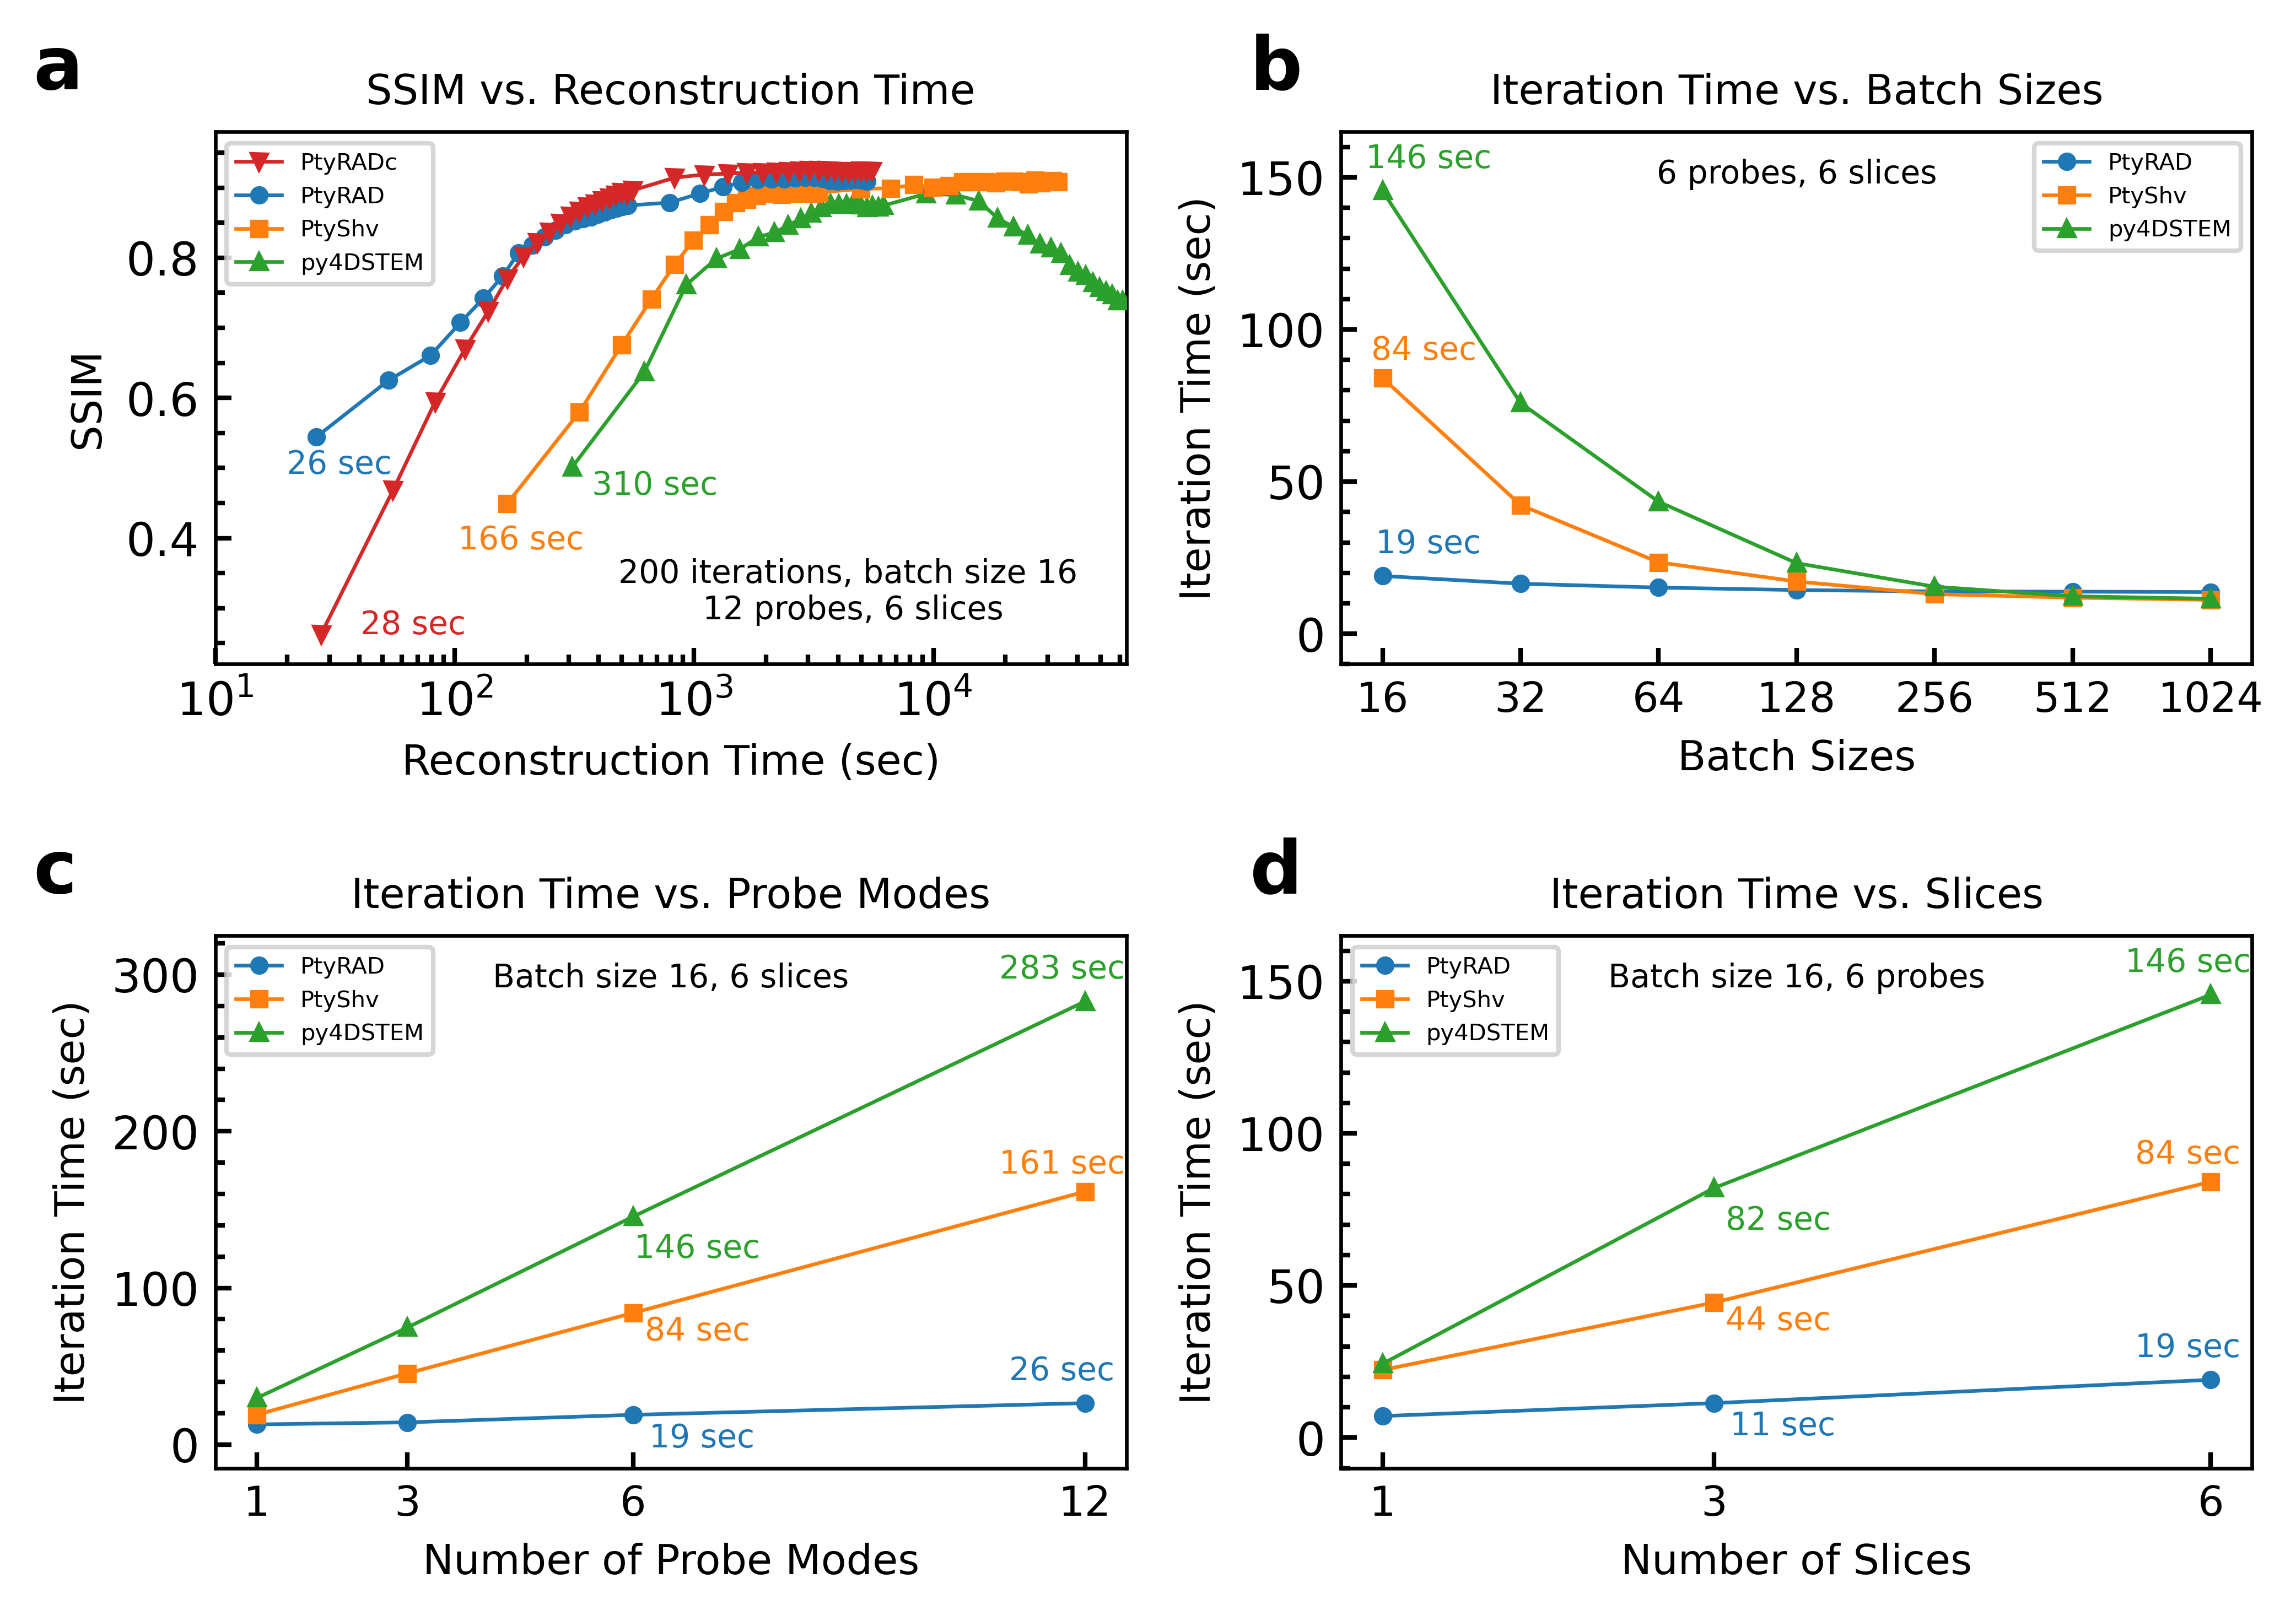

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as tck

mpl.rc('xtick', direction='in')
mpl.rc('xtick.major', width=1, size=3.5)
mpl.rc('xtick.minor', width=1, size=2)
mpl.rc('ytick', direction='in')
mpl.rc('ytick.major', width=1, size=3.5)
mpl.rc('ytick.minor', width=1, size=2)

# Plot Data
# Note that these data are all computed on 20GB slice

iterations = np.array([i for i in range(1,20)] + [i for i in range(20,210,10)])

batch_sizes = np.array([16, 32, 64, 128, 256, 512, 1024])
time_ptyrad_batch = np.array([19.0, 16.45, 15.18, 14.37, 13.91, 13.84, 13.71])
time_ptyshv_batch = np.array([84.08, 42.31, 23.47, 17.18, 13.02, 11.87, 11.15])
time_py4dstem_batch = np.array([145.57, 75.85, 43.40, 23.20, 15.47, 12.32, 11.51])

probe_modes = np.array([1, 3, 6, 12])
time_ptyrad_modes = np.array([12.87, 14.18, 19.00, 26.46])
time_ptyshv_modes = np.array([19.07, 45.46, 84.08, 161.49])
time_py4dstem_modes = np.array([29.70, 74.71, 145.57, 282.91])

num_slices = np.array([1, 3, 6])
time_ptyrad_slices = np.array([7.09, 11.34, 19.00])
time_ptyshv_slices = np.array([22.24, 44.38, 84.08])
time_py4dstem_slices = np.array([24.26, 82.01, 145.57])

# Speedup factor
speedup_factor_iter = iter_time_py4dstem/iter_time_ptyrad
speedup_factor_batch = time_py4dstem_batch[0] / time_ptyrad_batch[0]
speedup_factor_modes = time_py4dstem_modes[-1] / time_ptyrad_modes[-1]
speedup_factor_slices = time_py4dstem_slices[-1] / time_ptyrad_slices[-1]

# Global font/line control
linewidth = 0.8
markersize = 3
fontsize_title = 9
fontsize_subtitle = 7
fontsize_label = 9
fontsize_legend = 5
annotate_size = 7

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(7, 5), dpi=600)

# Panel 1: Error vs. Iteration
axes[0, 0].plot(iterations[:len(ssims_ptyrad_c)]*iter_time_ptyrad_c, ssims_ptyrad_c, label='PtyRADc', marker='v', linewidth=linewidth, markersize=markersize, zorder=10, color='C3')
axes[0, 0].plot(iterations[:len(ssims_ptyrad)]  *iter_time_ptyrad, ssims_ptyrad, label='PtyRAD', marker='o', linewidth=linewidth, markersize=markersize, zorder=8, color='C0')
axes[0, 0].plot(iterations[:len(ssims_ptyshv)]  *iter_time_ptyshv, ssims_ptyshv, label='PtyShv', marker='s', linewidth=linewidth, markersize=markersize, zorder=7, color='C1')
axes[0, 0].plot(iterations[:len(ssims_py4dstem)]*iter_time_py4dstem, ssims_py4dstem, label='py4DSTEM', marker='^', linewidth=linewidth, markersize=markersize, zorder=6, color='C2')

axes[0, 0].set_title('SSIM vs. Reconstruction Time', fontsize=fontsize_title)
axes[0, 0].text(0.70, 0.20, '200 iterations, batch size 16 \n12 probes, 6 slices', 
                transform=axes[0, 0].transAxes, ha='center', va='top', fontsize=fontsize_subtitle, color='k')
axes[0, 0].set_xlabel('Reconstruction Time (sec)', fontsize=fontsize_label)
axes[0, 0].set_ylabel('SSIM', fontsize=fontsize_label)
axes[0, 0].text(-0.2, 1.08, 'a', transform=axes[0, 0].transAxes, fontsize=16, fontweight='bold')  # Label "a"
axes[0, 0].annotate(f'{iter_time_ptyrad_c:.0f} sec', (iter_time_ptyrad_c, ssims_ptyrad_c[0]), textcoords="offset points", xytext=(20,0), ha='center', color='C3', fontsize=annotate_size)
axes[0, 0].annotate(f'{iter_time_ptyrad:.0f} sec', (iter_time_ptyrad, ssims_ptyrad[0]), textcoords="offset points", xytext=(5,-8), ha='center', color='C0', fontsize=annotate_size)
axes[0, 0].annotate(f'{iter_time_ptyshv:.0f} sec', (iter_time_ptyshv, ssims_ptyshv[0]), textcoords="offset points", xytext=(3,-10), ha='center', color='C1', fontsize=annotate_size)
axes[0, 0].annotate(f'{iter_time_py4dstem:.0f} sec', (iter_time_py4dstem, ssims_py4dstem[0]), textcoords="offset points", xytext=(18,-6), ha='center', color='C2', fontsize=annotate_size)

axes[0, 0].legend(fontsize=fontsize_legend)
axes[0, 0].set_xscale('log')
axes[0, 0].set_xlim(10, 64000)
axes[0, 0].set_ylim(0.22,0.98)
axes[0, 0].yaxis.set_minor_locator(tck.AutoMinorLocator())

# Panel 2: Iter Time vs. Batch Sizes
axes[0, 1].plot(np.arange(len(batch_sizes)), time_ptyrad_batch, label='PtyRAD', marker='o', linewidth=linewidth, markersize=markersize)
axes[0, 1].plot(np.arange(len(batch_sizes)), time_ptyshv_batch, label='PtyShv', marker='s', linewidth=linewidth, markersize=markersize)
axes[0, 1].plot(np.arange(len(batch_sizes)), time_py4dstem_batch, label='py4DSTEM', marker='^', linewidth=linewidth, markersize=markersize)
axes[0, 1].set_title('Iteration Time vs. Batch Sizes', fontsize=fontsize_title)
axes[0, 1].text(0.5, 0.95, '6 probes, 6 slices', transform=axes[0, 1].transAxes, 
                ha='center', va='top', fontsize=fontsize_subtitle, color='k')
axes[0, 1].set_xlabel('Batch Sizes', fontsize=fontsize_label)
axes[0, 1].set_ylabel('Iteration Time (sec)', fontsize=fontsize_label)
axes[0, 1].set_xticks(np.arange(len(batch_sizes)))
axes[0, 1].set_xticklabels([str(int(b)) for b in batch_sizes], fontsize=fontsize_label)
axes[0, 1].text(-0.1, 1.08, 'b', transform=axes[0, 1].transAxes, fontsize=16, fontweight='bold')  # Label "b"
axes[0, 1].annotate(f'{time_ptyrad_batch[0]:.0f} sec', (0, time_ptyrad_batch[0]), textcoords="offset points", xytext=(10,5), ha='center', color='C0', fontsize=annotate_size)
axes[0, 1].annotate(f'{time_ptyshv_batch[0]:.0f} sec', (0, time_ptyshv_batch[0]), textcoords="offset points", xytext=(9,4), ha='center', color='C1', fontsize=annotate_size)
axes[0, 1].annotate(f'{time_py4dstem_batch[0]:.0f} sec', (0, time_py4dstem_batch[0]), textcoords="offset points", xytext=(10,5), ha='center', color='C2', fontsize=annotate_size)

axes[0, 1].legend(fontsize=fontsize_legend)
axes[0, 1].set_ylim(-10,165)
axes[0, 1].yaxis.set_minor_locator(tck.AutoMinorLocator())

# Panel 3: Iter Time vs. Probe Modes
axes[1, 0].plot(probe_modes, time_ptyrad_modes, label='PtyRAD', marker='o', linewidth=linewidth, markersize=markersize)
axes[1, 0].plot(probe_modes, time_ptyshv_modes, label='PtyShv', marker='s', linewidth=linewidth, markersize=markersize)
axes[1, 0].plot(probe_modes, time_py4dstem_modes, label='py4DSTEM', marker='^', linewidth=linewidth, markersize=markersize)
axes[1, 0].set_title('Iteration Time vs. Probe Modes', fontsize=fontsize_title)
axes[1, 0].text(0.5, 0.95, 'Batch size 16, 6 slices', transform=axes[1, 0].transAxes, 
                ha='center', va='top', fontsize=fontsize_subtitle, color='k')
axes[1, 0].set_xlabel('Number of Probe Modes', fontsize=fontsize_label)
axes[1, 0].set_ylabel('Iteration Time (sec)', fontsize=fontsize_label)
axes[1, 0].set_xticks(probe_modes)
axes[1, 0].set_xticklabels([str(int(p)) for p in probe_modes], fontsize=fontsize_label)
axes[1, 0].text(-0.2, 1.08, 'c', transform=axes[1, 0].transAxes, fontsize=16, fontweight='bold')  # Label "c"
axes[1, 0].annotate(f'{time_ptyrad_modes[-2]:.0f} sec', (probe_modes[-2], time_ptyrad_modes[-2]), textcoords="offset points", xytext=(15,-7), ha='center', color='C0', fontsize=annotate_size)
axes[1, 0].annotate(f'{time_ptyshv_modes[-2]:.0f} sec', (probe_modes[-2], time_ptyshv_modes[-2]), textcoords="offset points", xytext=(14,-6), ha='center', color='C1', fontsize=annotate_size)
axes[1, 0].annotate(f'{time_py4dstem_modes[-2]:.0f} sec', (probe_modes[-2], time_py4dstem_modes[-2]), textcoords="offset points", xytext=(14,-9), ha='center', color='C2', fontsize=annotate_size)

axes[1, 0].annotate(f'{time_ptyrad_modes[-1]:.0f} sec', (probe_modes[-1], time_ptyrad_modes[-1]), textcoords="offset points", xytext=(-5,5), ha='center', color='C0', fontsize=annotate_size)
axes[1, 0].annotate(f'{time_ptyshv_modes[-1]:.0f} sec', (probe_modes[-1], time_ptyshv_modes[-1]), textcoords="offset points", xytext=(-5,4), ha='center', color='C1', fontsize=annotate_size)
axes[1, 0].annotate(f'{time_py4dstem_modes[-1]:.0f} sec', (probe_modes[-1], time_py4dstem_modes[-1]), textcoords="offset points", xytext=(-5,5), ha='center', color='C2', fontsize=annotate_size)

axes[1, 0].legend(fontsize=fontsize_legend)
axes[1, 0].set_ylim(-15,325)
axes[1, 0].yaxis.set_minor_locator(tck.AutoMinorLocator())

# Panel 4: Iter Time vs. Slices
axes[1, 1].plot(num_slices, time_ptyrad_slices, label='PtyRAD', marker='o', linewidth=linewidth, markersize=markersize)
axes[1, 1].plot(num_slices, time_ptyshv_slices, label='PtyShv', marker='s', linewidth=linewidth, markersize=markersize)
axes[1, 1].plot(num_slices, time_py4dstem_slices, label='py4DSTEM', marker='^', linewidth=linewidth, markersize=markersize)
axes[1, 1].set_title('Iteration Time vs. Slices', fontsize=fontsize_title)
axes[1, 1].text(0.5, 0.95, 'Batch size 16, 6 probes', transform=axes[1, 1].transAxes, 
                ha='center', va='top', fontsize=fontsize_subtitle, color='k')
axes[1, 1].set_xlabel('Number of Slices', fontsize=fontsize_label)
axes[1, 1].set_ylabel('Iteration Time (sec)', fontsize=fontsize_label)
axes[1, 1].set_xticks(num_slices)
axes[1, 1].set_xticklabels(num_slices, fontsize=fontsize_label)
axes[1, 1].text(-0.1, 1.08, 'd', transform=axes[1, 1].transAxes, fontsize=16, fontweight='bold')  # Label "d"

axes[1, 1].annotate(f'{time_ptyrad_slices[-2]:.0f} sec', (num_slices[-2], time_ptyrad_slices[-2]), textcoords="offset points", xytext=(15,-7), ha='center', color='C0', fontsize=annotate_size)
axes[1, 1].annotate(f'{time_ptyshv_slices[-2]:.0f} sec', (num_slices[-2], time_ptyshv_slices[-2]), textcoords="offset points", xytext=(14,-6), ha='center', color='C1', fontsize=annotate_size)
axes[1, 1].annotate(f'{time_py4dstem_slices[-2]:.0f} sec', (num_slices[-2], time_py4dstem_slices[-2]), textcoords="offset points", xytext=(14,-9), ha='center', color='C2', fontsize=annotate_size)

axes[1, 1].annotate(f'{time_ptyrad_slices[-1]:.0f} sec', (num_slices[-1], time_ptyrad_slices[-1]), textcoords="offset points", xytext=(-5,5), ha='center', color='C0', fontsize=annotate_size)
axes[1, 1].annotate(f'{time_ptyshv_slices[-1]:.0f} sec', (num_slices[-1], time_ptyshv_slices[-1]), textcoords="offset points", xytext=(-5,4), ha='center', color='C1', fontsize=annotate_size)
axes[1, 1].annotate(f'{time_py4dstem_slices[-1]:.0f} sec', (num_slices[-1], time_py4dstem_slices[-1]), textcoords="offset points", xytext=(-5,5), ha='center', color='C2', fontsize=annotate_size)

axes[1, 1].legend(fontsize=fontsize_legend)
axes[1, 1].set_ylim(-10,165)
axes[1, 1].yaxis.set_minor_locator(tck.AutoMinorLocator())

# Adjust layout
plt.tight_layout()
fig_name = 'Fig_03_iter_time_comparison'
plt.savefig(f"05_figures/{fig_name}.pdf", bbox_inches="tight")

plt.show()